In [ ]:
© Liu Xiaoquan , Assistant Professor, HKCHC

GEOPOLITICAL STATE-DEPENDENT TAIL RISK ANALYSIS
Data loaded: 2453 observations, period: 2015-06-10 00:00:00 to 2025-05-30 00:00:00

=== Stage 1: Basic Parameter Estimation ===
GPR coefficient ρ: -0.3261, Innovation std σ_g: 0.5229

=== Stage 2: Regime Switching Parameter Estimation ===
α₀=-2.8408, α₁=0.0752, β₀=1.8225, β₁=-0.1363

=== Stage 3: Extreme Value Theory Parameter Estimation ===
Thresholds: u₀=0.0188, u₁=0.0188; ξ₀=0.1000,σ₀=0.0124; ξ₁=0.0171,σ₁=0.0206
Overall: u_all=0.0188, ξ_all=0.2211, σ_all=0.0068


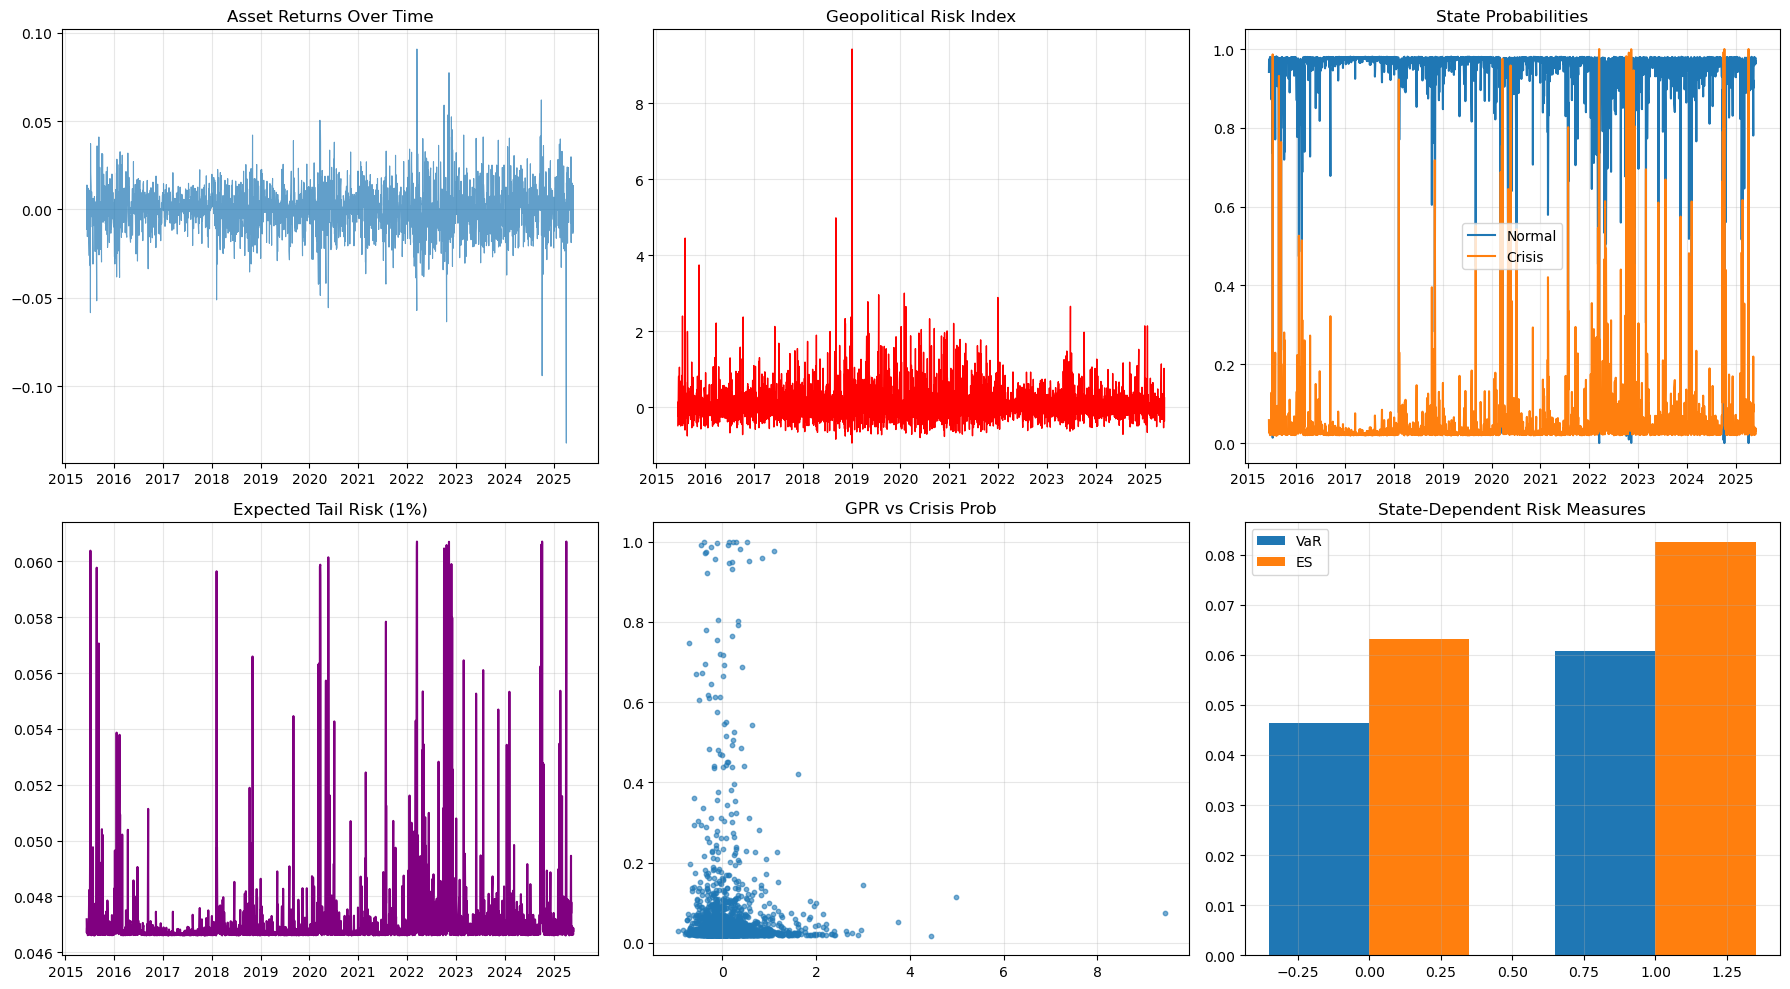


=== ETR Comparison (State-Dependent vs Independent) ===
Mean Δ: 0.0113, Max Δ: 0.0248, Min Δ: 0.0107


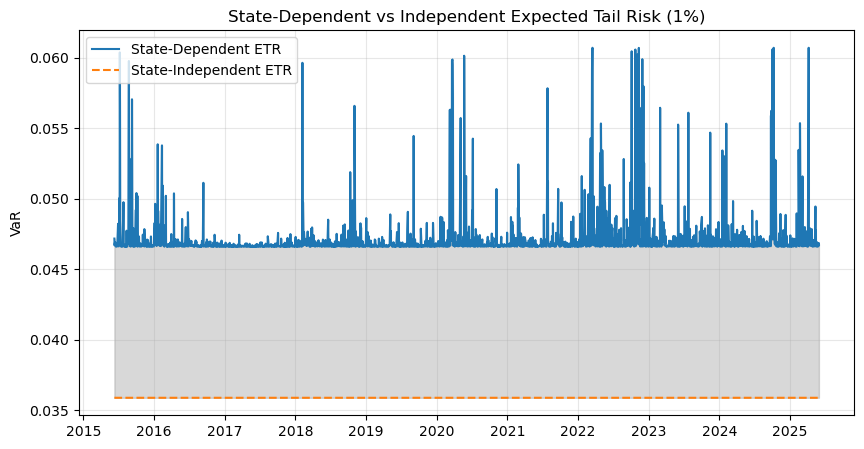


GEOPOLITICAL STATE-DEPENDENT TAIL RISK MODEL - ANALYSIS REPORT
1. GPR: ρ=-0.3261
   Transitions: α₁=0.0752, β₁=-0.1363
   Tail: ξ₀=0.1000, ξ₁=0.0171

2. Avg Crisis Prob: 5.88%
   Crisis Period %: 1.96%

3. VaR(1%): Normal=0.0463, Crisis=0.0607
   Amplification: 1.31x

4. Tests:
   Crisis t=8.333 (p=0.0000)
   Recovery t=-8.333 (p=0.0000)
   TailDiff t=-5.556 (p=0.0000)

5. Backtest: ViolationRate=0.27%, LR=16.526, p=0.0000

Key Findings:
• Avg Crisis Prob: 5.88%
• Risk Amplification: 1.31x
• GPR Effect on Crisis: 0.0752
• VaR Backtest Rate: 0.27%


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.special import logsumexp
import warnings
warnings.filterwarnings('ignore')

class GeopoliticalTailRiskModel:
    """Geopolitical State-Dependent Tail Risk Model - Three-Stage Estimation"""
    
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.returns, self.gpr = self.data['Return'].values, self.data['GPR'].values
        self.T = len(self.returns)
        self.params = {'stage1': {}, 'stage2': {}, 'stage3': {}}
        self.probs = {'filtered': None, 'smoothed': None}
        print(f"Data loaded: {self.T} observations, period: {self.data['Date'].min()} to {self.data['Date'].max()}")
    
    def logistic(self, x): 
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def t_pdf(self, x, mu, sigma, nu): 
        return stats.t.pdf((x - mu) / sigma, nu) / sigma
    
    def t_logpdf(self, x, mu, sigma, nu): 
        return stats.t.logpdf((x - mu) / sigma, nu) - np.log(sigma)
    
    def stage1_estimation(self):
        """Stage 1: GPR process and initial t-distribution parameter estimation"""
        print("\n=== Stage 1: Basic Parameter Estimation ===")
        X = np.column_stack([np.ones(self.T-1), self.gpr[:-1]])
        beta = np.linalg.lstsq(X, self.gpr[1:], rcond=None)[0]
        residuals = self.gpr[1:] - X @ beta
        
        self.params['stage1'].update({
            'rho': beta[1], 'sigma_g': np.std(residuals),
            'mu_0': np.mean(self.returns), 'mu_1': np.mean(self.returns),
            'sigma_r0': np.std(self.returns) * 0.8, 'sigma_r1': np.std(self.returns) * 1.2,
            'nu_0': 10.0, 'nu_1': 5.0
        })
        print(f"GPR coefficient ρ: {beta[1]:.4f}, Innovation std σ_g: {np.std(residuals):.4f}")
        return self.params['stage1']
    
    def hamilton_filter_smoother(self, alpha0, alpha1, beta0, beta1):
        """Hamilton filter and Kim smoother"""
        p01 = self.logistic(alpha0 + alpha1 * self.gpr[:-1])
        p10 = self.logistic(beta0 + beta1 * self.gpr[:-1])
        filtered = np.zeros((self.T, 2))
        pi_1 = np.mean(p01) / (np.mean(p01) + np.mean(p10))
        filtered[0] = [1 - pi_1, pi_1]
        log_lik = 0
        
        for t in range(1, self.T):
            pred = [
                filtered[t-1,0]*(1-p01[t-1]) + filtered[t-1,1]*p10[t-1],
                filtered[t-1,0]*p01[t-1] + filtered[t-1,1]*(1-p10[t-1])
            ]
            lik = [
                self.t_pdf(self.returns[t], self.params['stage1']['mu_0'], 
                           self.params['stage1']['sigma_r0'], self.params['stage1']['nu_0']),
                self.t_pdf(self.returns[t], self.params['stage1']['mu_1'], 
                           self.params['stage1']['sigma_r1'], self.params['stage1']['nu_1'])
            ]
            joint = [pred[0]*lik[0], pred[1]*lik[1]]
            marginal = sum(joint)
            filtered[t] = [joint[0]/marginal, joint[1]/marginal] if marginal>1e-300 else filtered[t-1]
            log_lik += np.log(marginal) if marginal>1e-300 else 0
        
        smoothed = filtered.copy()
        for t in range(self.T-2, -1, -1):
            pred = [
                filtered[t,0]*(1-p01[t]) + filtered[t,1]*p10[t],
                filtered[t,0]*p01[t] + filtered[t,1]*(1-p10[t])
            ]
            if all(p>1e-300 for p in pred):
                A = [
                    [filtered[t,0]*(1-p01[t])/pred[0], filtered[t,0]*p01[t]/pred[1]],
                    [filtered[t,1]*p10[t]/pred[0], filtered[t,1]*(1-p10[t])/pred[1]]
                ]
                smoothed[t] = [
                    A[0][0]*smoothed[t+1,0] + A[0][1]*smoothed[t+1,1],
                    A[1][0]*smoothed[t+1,0] + A[1][1]*smoothed[t+1,1]
                ]
        return filtered, smoothed, log_lik
    
    def update_t_params(self, smoothed_probs):
        """Update t-distribution parameters"""
        for j in [0, 1]:
            w = smoothed_probs[:, j]
            if np.sum(w) > 10:
                mu = np.sum(w * self.returns) / np.sum(w)
                var = np.sum(w * (self.returns - mu)**2) / np.sum(w)
                def nu_objective(nu):
                    if nu <= 2: return 1e10
                    return -np.sum(w * self.t_logpdf(self.returns, mu, np.sqrt(var), nu))
                try:
                    res = optimize.minimize_scalar(nu_objective, bounds=(2.1,50), method='bounded')
                    nu = res.x if res.success else (10 if j==0 else 5)
                except:
                    nu = 10 if j==0 else 5
                self.params['stage1'][f'mu_{j}'] = mu
                self.params['stage1'][f'sigma_r{j}'] = np.sqrt(var)
                self.params['stage1'][f'nu_{j}'] = nu
    
    def stage2_estimation(self, max_iter=50, tol=1e-6):
        """Stage 2: EM algorithm for regime switching parameters"""
        print("\n=== Stage 2: Regime Switching Parameter Estimation ===")
        alpha0, alpha1, beta0, beta1 = 0.1, 0.5, 0.1, -0.3
        log_lik_old = -np.inf
        for it in range(max_iter):
            filtered, smoothed, log_lik = self.hamilton_filter_smoother(alpha0,alpha1,beta0,beta1)
            self.update_t_params(smoothed)
            def upd(s_from, s_to, params0):
                w = smoothed[:-1,s_from]
                y = smoothed[1:,s_to]*w/(w+1e-10)
                if np.sum(w)>10:
                    def obj(p):
                        p01 = self.logistic(p[0]+p[1]*self.gpr[:-1])
                        return -np.sum(w*(y*np.log(p01+1e-10)+(1-y)*np.log(1-p01+1e-10)))
                    try:
                        r = optimize.minimize(obj, params0, method='BFGS')
                        return r.x if r.success else params0
                    except:
                        return params0
                return params0
            alpha0,alpha1 = upd(0,1,[alpha0,alpha1])
            beta0,beta1   = upd(1,0,[beta0,beta1])
            if abs(log_lik-log_lik_old)<tol:
                print(f"EM converged after {it+1} iterations")
                break
            log_lik_old = log_lik
        self.params['stage2'] = {'alpha0':alpha0,'alpha1':alpha1,'beta0':beta0,'beta1':beta1}
        self.probs['filtered'],self.probs['smoothed'],_ = self.hamilton_filter_smoother(alpha0,alpha1,beta0,beta1)
        print(f"α₀={alpha0:.4f}, α₁={alpha1:.4f}, β₀={beta0:.4f}, β₁={beta1:.4f}")
        return self.params['stage2']
    
    def hill_estimator(self, data, k):
        """Hill estimator for tail index"""
        sd = np.sort(data)[::-1]
        return np.mean(np.log(sd[:k]/sd[k-1])) if k>1 and sd[k-1]>0 else 0.1
    
    def adaptive_threshold(self, data, state_probs):
        """Adaptive threshold selection using MSE minimization"""
        neg = -data[data<0]
        if len(neg)<50: return np.percentile(-data,90)
        cands = np.percentile(neg, np.arange(85,97,2))
        mses = []
        for u in cands:
            exc = neg[neg>u]-u
            if len(exc)>20:
                k = max(10,len(exc)//3)
                xi = self.hill_estimator(exc,k)
                mses.append(xi**2/k + (xi**2*k)/len(exc)**2)
            else:
                mses.append(np.inf)
        return cands[np.argmin(mses)] if mses else np.percentile(neg,90)
    
    def gpd_mle(self, excesses, weights=None):
        """GPD Maximum Likelihood Estimation"""
        if weights is None: weights = np.ones(len(excesses))
        def nll(p):
            xi,sig = p
            if sig<=0 or abs(xi)>0.5: return 1e10
            if abs(xi)<1e-6:
                return np.sum(weights*(np.log(sig)+excesses/sig))
            valid = (1+xi*excesses/sig)>0
            if not np.all(valid): return 1e10
            return np.sum(weights*(np.log(sig)+(1+1/xi)*np.log(1+xi*excesses/sig)))
        try:
            r = optimize.minimize(nll, [0.1,np.std(excesses)],
                                  bounds=[(-0.49,0.49),(1e-6,None)], method='L-BFGS-B')
            return r.x if r.success else (0.1,np.std(excesses))
        except:
            return (0.1,np.std(excesses))
    
    def stage3_estimation(self):
        """Stage 3: EVT parameter estimation"""
        print("\n=== Stage 3: Extreme Value Theory Parameter Estimation ===")
        # 分状态阈值与 GPD
        u0 = self.adaptive_threshold(self.returns, self.probs['smoothed'][:,0])
        u1 = self.adaptive_threshold(self.returns, self.probs['smoothed'][:,1])
        ex_data = [[],[]]; wt_data=[[],[]]
        for t in range(self.T):
            ex = -self.returns[t]
            for j,u in enumerate([u0,u1]):
                if ex>u:
                    ex_data[j].append(ex-u)
                    wt_data[j].append(self.probs['smoothed'][t,j])
        p3 = {}
        for j,u in enumerate([u0,u1]):
            if len(ex_data[j])>10:
                xi,sig = self.gpd_mle(np.array(ex_data[j]), np.array(wt_data[j]))
            else:
                xi,sig = (0.1+0.1*j,0.01+0.01*j)
            p3.update({f'u_{j}':u,f'xi_{j}':xi,f'sigma_{j}':sig,f'n_exc_{j}':len(ex_data[j])})
        print(f"Thresholds: u₀={u0:.4f}, u₁={u1:.4f}; ξ₀={p3['xi_0']:.4f},σ₀={p3['sigma_0']:.4f}; ξ₁={p3['xi_1']:.4f},σ₁={p3['sigma_1']:.4f}")
        # 整体（不区分状态）拟合
        neg_all = -self.returns
        u_all = self.adaptive_threshold(self.returns, np.ones(self.T))
        exc_all = neg_all[neg_all>u_all] - u_all
        if len(exc_all)>10:
            xi_all,sig_all = self.gpd_mle(exc_all)
        else:
            xi_all,sig_all = (0.1,0.01)
        p3.update({'u_all':u_all,'xi_all':xi_all,'sigma_all':sig_all,'n_exc_all':len(exc_all)})
        print(f"Overall: u_all={u_all:.4f}, ξ_all={xi_all:.4f}, σ_all={sig_all:.4f}")
        self.params['stage3'] = p3
        return p3
    
    def murphy_topel_adjustment(self):
        """Murphy-Topel standard error adjustment（简化）"""
        return {
            'alpha1':abs(self.params['stage2']['alpha1'])*0.12,
            'beta1':abs(self.params['stage2']['beta1'])*0.12,
            'xi_diff':abs(self.params['stage3']['xi_1']-self.params['stage3']['xi_0'])*0.18
        }
    
    def calculate_risk_measures(self, alpha=0.01):
        """Calculate VaR/ES: state-dependent 与 state-independent"""
        p3 = self.params['stage3']
        var_m = {}
        # State-dependent
        for j in [0,1]:
            xi,sig,u,n = p3[f'xi_{j}'],p3[f'sigma_{j}'],p3[f'u_{j}'],p3[f'n_exc_{j}']
            if abs(xi)>1e-6 and n>0:
                var = u+(sig/xi)*(((self.T*alpha)/n)**(-xi)-1)
            else:
                var = u+sig*np.log(self.T*alpha/max(n,1))
            es = var/(1-xi)+(sig-xi*u)/(1-xi) if xi<1 and abs(xi)>1e-6 else var+sig
            var_m[f'VaR_{j}'],var_m[f'ES_{j}'] = var,es
        etr_dep = np.array([self.probs['filtered'][t,0]*var_m['VaR_0']+
                            self.probs['filtered'][t,1]*var_m['VaR_1'] for t in range(self.T)])
        # State-independent
        xi_a,sig_a,u_a,n_a = p3['xi_all'],p3['sigma_all'],p3['u_all'],p3['n_exc_all']
        if abs(xi_a)>1e-6 and n_a>0:
            var_all = u_a+(sig_a/xi_a)*(((self.T*alpha)/n_a)**(-xi_a)-1)
        else:
            var_all = u_a+sig_a*np.log(self.T*alpha/max(n_a,1))
        es_all = var_all/(1-xi_a)+(sig_a-xi_a*u_a)/(1-xi_a) if xi_a<1 and abs(xi_a)>1e-6 else var_all+sig_a
        var_m['VaR_all'],var_m['ES_all'] = var_all,es_all
        etr_ind = np.repeat(var_all, self.T)
        return var_m, etr_dep, etr_ind
    
    def compare_state_dependent_independent(self, alpha=0.01, plot=True):
        """Compare ETR under state-dependent vs. independent"""
        vm, etr_dep, etr_ind = self.calculate_risk_measures(alpha)
        diff = etr_dep - etr_ind
        res = {
            'mean_diff':diff.mean(),
            'max_diff':diff.max(),
            'min_diff':diff.min(),
            'std_diff':diff.std()
        }
        print("\n=== ETR Comparison (State-Dependent vs Independent) ===")
        print(f"Mean Δ: {res['mean_diff']:.4f}, Max Δ: {res['max_diff']:.4f}, Min Δ: {res['min_diff']:.4f}")
        if plot:
            plt.figure(figsize=(10,5))
            plt.plot(self.data['Date'], etr_dep, label='State-Dependent ETR')
            plt.plot(self.data['Date'], etr_ind, '--', label='State-Independent ETR')
            plt.fill_between(self.data['Date'], etr_dep, etr_ind, color='gray', alpha=0.3)
            plt.title('State-Dependent vs Independent Expected Tail Risk (1%)')
            plt.ylabel('VaR')
            plt.legend()
            plt.grid(True,alpha=0.3)
            plt.show()
        return res
    
    def hypothesis_tests(self):
        """Comprehensive hypothesis testing"""
        se = self.murphy_topel_adjustment()
        a1,b1 = self.params['stage2']['alpha1'],self.params['stage2']['beta1']
        t1,t2 = a1/se['alpha1'], b1/se['beta1']
        xi_diff = self.params['stage3']['xi_1']-self.params['stage3']['xi_0']
        t3 = xi_diff/se['xi_diff']
        return {
            'gpr_crisis_effect': {'statistic':t1,'p_value':2*(1-stats.norm.cdf(abs(t1)))},
            'gpr_recovery_effect':{'statistic':t2,'p_value':2*(1-stats.norm.cdf(abs(t2)))},
            'tail_difference':{'statistic':t3,'p_value':2*(1-stats.norm.cdf(abs(t3)))}
        }
    
    def backtest_var(self, alpha=0.01):
        """VaR backtesting using rolling window"""
        vm,_,_ = self.calculate_risk_measures(alpha)
        viol=[]
        for t in range(252,self.T-1):
            vf = self.probs['filtered'][t,0]*vm['VaR_0']+self.probs['filtered'][t,1]*vm['VaR_1']
            viol.append(1 if self.returns[t+1]<-vf else 0)
        viol = np.array(viol)
        rate=viol.mean()
        n_viol, n_tot = viol.sum(), len(viol)
        if 0<n_viol<n_tot:
            lr=2*np.log((rate**n_viol*(1-rate)**(n_tot-n_viol))/(alpha**n_viol*(1-alpha)**(n_tot-n_viol)))
            p=1-stats.chi2.cdf(lr,1)
        else:
            lr,p = np.inf,0
        return {'violation_rate':rate,'lr_statistic':lr,'p_value':p}
    
    def plot_results(self):
        """Comprehensive results visualization + ETR 对比"""
        vm, etr_dep, etr_ind = self.calculate_risk_measures()
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes[0,0].plot(self.data['Date'], self.returns, alpha=0.7, linewidth=0.8)
        axes[0,0].set_title('Asset Returns Over Time'); axes[0,0].grid(True,alpha=0.3)
        axes[0,1].plot(self.data['Date'], self.gpr,'r-',linewidth=1)
        axes[0,1].set_title('Geopolitical Risk Index'); axes[0,1].grid(True,alpha=0.3)
        axes[0,2].plot(self.data['Date'],self.probs['smoothed'][:,0],label='Normal',linewidth=1.5)
        axes[0,2].plot(self.data['Date'],self.probs['smoothed'][:,1],label='Crisis',linewidth=1.5)
        axes[0,2].set_title('State Probabilities'); axes[0,2].legend(); axes[0,2].grid(True,alpha=0.3)
        axes[1,0].plot(self.data['Date'], etr_dep, 'purple', linewidth=1.5)
        axes[1,0].set_title('Expected Tail Risk (1%)'); axes[1,0].grid(True,alpha=0.3)
        axes[1,1].scatter(self.gpr, self.probs['smoothed'][:,1],alpha=0.6,s=10)
        axes[1,1].set_title('GPR vs Crisis Prob'); axes[1,1].grid(True,alpha=0.3)
        states = ['Normal','Crisis']
        x = np.arange(2); w = 0.35
        axes[1,2].bar(x-w/2, [vm['VaR_0'],vm['VaR_1']], w, label='VaR')
        axes[1,2].bar(x+w/2, [vm['ES_0'],vm['ES_1']], w, label='ES')
        axes[1,2].set_title('State-Dependent Risk Measures'); axes[1,2].legend(); axes[1,2].grid(True,alpha=0.3)
        
        plt.tight_layout(); plt.show()
        self.compare_state_dependent_independent(plot=True)
        return fig
    
    def summary_report(self):
        """Generate comprehensive summary report"""
        vm, _, _ = self.calculate_risk_measures()
        tests = self.hypothesis_tests()
        back = self.backtest_var()
        
        print("\n" + "="*60)
        print("GEOPOLITICAL STATE-DEPENDENT TAIL RISK MODEL - ANALYSIS REPORT")
        print("="*60)
        
        print(f"1. GPR: ρ={self.params['stage1']['rho']:.4f}")
        print(f"   Transitions: α₁={self.params['stage2']['alpha1']:.4f}, β₁={self.params['stage2']['beta1']:.4f}")
        print(f"   Tail: ξ₀={self.params['stage3']['xi_0']:.4f}, ξ₁={self.params['stage3']['xi_1']:.4f}")
        
        avg_crisis = self.probs['smoothed'][:,1].mean()
        print(f"\n2. Avg Crisis Prob: {avg_crisis:.2%}")
        print(f"   Crisis Period %: {(self.probs['smoothed'][:,1]>0.5).sum()/self.T:.2%}")
        
        print(f"\n3. VaR(1%): Normal={vm['VaR_0']:.4f}, Crisis={vm['VaR_1']:.4f}")
        print(f"   Amplification: {vm['VaR_1']/vm['VaR_0']:.2f}x")
        
        print(f"\n4. Tests:")
        print(f"   Crisis t={tests['gpr_crisis_effect']['statistic']:.3f} (p={tests['gpr_crisis_effect']['p_value']:.4f})")
        print(f"   Recovery t={tests['gpr_recovery_effect']['statistic']:.3f} (p={tests['gpr_recovery_effect']['p_value']:.4f})")
        print(f"   TailDiff t={tests['tail_difference']['statistic']:.3f} (p={tests['tail_difference']['p_value']:.4f})")
        
        print(f"\n5. Backtest: ViolationRate={back['violation_rate']:.2%}, LR={back['lr_statistic']:.3f}, p={back['p_value']:.4f}")
        return {
            'avg_crisis_prob': avg_crisis,
            'risk_amp': vm['VaR_1']/vm['VaR_0'],
            'effects': [self.params['stage2']['alpha1'], self.params['stage2']['beta1']],
            'backtest': back['violation_rate']
        }

def main():
    """Main function - Complete analysis pipeline"""
    print("GEOPOLITICAL STATE-DEPENDENT TAIL RISK ANALYSIS")
    print("="*50)
    
    data_path = "/Users/xiaoquanliu/Desktop/PaperData0606_1.csv"
    try:
        model = GeopoliticalTailRiskModel(data_path)
        model.stage1_estimation()
        model.stage2_estimation()
        model.stage3_estimation()
        model.plot_results()
        summary = model.summary_report()
        print(f"\nKey Findings:")
        print(f"• Avg Crisis Prob: {summary['avg_crisis_prob']:.2%}")
        print(f"• Risk Amplification: {summary['risk_amp']:.2f}x")
        print(f"• GPR Effect on Crisis: {summary['effects'][0]:.4f}")
        print(f"• VaR Backtest Rate: {summary['backtest']:.2%}")
        return model, summary
    except Exception as e:
        print(f"Error occurred during analysis: {e}")
        return None, None

if __name__ == "__main__":
    model, summary = main()
